In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score


In [2]:
df = pd.read_csv("data-p4/Flights1_2019_1.csv")
df

,YEAR,DAY_OF_WEEK,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_ABR,DEP_DELAY,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,Unnamed: 17
0,2019,6,2019-01-19,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,"Cincinnati, OH",KY,-10.0,1832.0,-25.0,0.0,0.0,NaN
1,2019,7,2019-01-20,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,"Cincinnati, OH",KY,-4.0,1825.0,-37.0,0.0,0.0,NaN
2,2019,1,2019-01-21,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,"Cincinnati, OH",KY,-9.0,1845.0,-17.0,0.0,0.0,NaN
3,2019,2,2019-01-22,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,"Cincinnati, OH",KY,-4.0,1839.0,-23.0,0.0,0.0,NaN
4,2019,3,2019-01-23,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,"Cincinnati, OH",KY,-6.0,1850.0,-12.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,2019,3,2019-01-30,14057,1405702,34057,"Portland, OR",13930,1393007,30977,"Chicago, IL",IL,-9.0,1225.0,-27.0,0.0,0.0,NaN
583981,2019,3,2019-01-30,13930,1393007,30977,"Chicago, IL",14908,1490803,32575,"Santa Ana, CA",CA,35.0,2230.0,17.0,17.0,1.0,NaN
583982,2019,3,2019-01-30,14635,1463502,31714,"Fort Myers, FL",13930,1393007,30977,"Chicago, IL",IL,132.0,2035.0,113.0,113.0,1.0,NaN
583983,2019,3,2019-01-30,11618,1161802,31703,"Newark, NJ",13930,1393007,30977,"Chicago, IL",IL,32.0,841.0,37.0,37.0,1.0,NaN


In [31]:
for i in df.columns.to_list():
    print(i)

YEAR
DAY_OF_WEEK
FL_DATE
ORIGIN_AIRPORT_ID
ORIGIN_AIRPORT_SEQ_ID
ORIGIN_CITY_MARKET_ID
ORIGIN_CITY_NAME
DEST_AIRPORT_ID
DEST_AIRPORT_SEQ_ID
DEST_CITY_MARKET_ID
DEST_CITY_NAME
DEST_STATE_ABR
DEP_DELAY
ARR_TIME
ARR_DELAY
ARR_DELAY_NEW
ARR_DEL15


In [3]:
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"]).dt.to_period('D')
df["YEAR"] = pd.to_datetime(df["YEAR"], format='%Y').dt.to_period('Y')

In [4]:
def safe_convert_to_time(value):
    try:
        if pd.notna(value) and np.isfinite(value):
            value_str = str(int(value)).zfill(4)  
            return pd.to_datetime(value_str, format='%H%M').time()
    except Exception:
        return None
    return None

df['ARR_TIME'] = df['ARR_TIME'].apply(safe_convert_to_time)

In [5]:
low_cardinality_int_cols = [col for col in df.select_dtypes(include=['int']).columns if df[col].nunique() < 10]
object_cols = df.select_dtypes(include=['object']).columns.tolist()
high_cardinality_int_cols = [col for col in df.select_dtypes(include=['int']).columns if df[col].nunique() >= 10]
continuous_cols = df.select_dtypes(include=['float']).columns.tolist()
period_cols = [col for col in df.columns if pd.api.types.is_period_dtype(df[col])]

dtypes = {
    "Column": [],
    "Type": [],
    "Domain": [],
    "Missing": []
}

for col in low_cardinality_int_cols + object_cols:
    unique_vals = df[col].dropna().unique()
    dtypes["Column"].append(col)
    dtypes["Type"].append("Low Cardinality Integer" if col in low_cardinality_int_cols else "Object")
    dtypes["Domain"].append(set(unique_vals))
    dtypes["Missing"].append(df[col].isna().sum())

for col in high_cardinality_int_cols + continuous_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    dtypes["Column"].append(col)
    dtypes["Type"].append("High Cardinality Integer" if col in high_cardinality_int_cols else "Continuous")
    dtypes["Domain"].append([min_val, max_val])
    dtypes["Missing"].append(df[col].isna().sum())

for col in period_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    dtypes["Column"].append(col)
    dtypes["Type"].append("Period")
    dtypes["Domain"].append(set([min_val]) if min_val == max_val else [min_val, max_val])
    dtypes["Missing"].append(df[col].isna().sum())

df_dtypes = pd.DataFrame(dtypes)
df_dtypes


/var/folders/8t/19klq0xd5w7cf39d3893ts0w0000gn/T/ipykernel_69184/4005902089.py:5: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  period_cols = [col for col in df.columns if pd.api.types.is_period_dtype(df[col])]


,Column,Type,Domain,Missing
0,DAY_OF_WEEK,Low Cardinality Integer,"{1, 2, 3, 4, 5, 6, 7}",0
1,ORIGIN_CITY_NAME,Object,"{Mobile, AL, Durango, CO, Jacksonville/Camp Le...",0
2,DEST_CITY_NAME,Object,"{Mobile, AL, Durango, CO, Jacksonville/Camp Le...",0
3,DEST_STATE_ABR,Object,"{AK, MA, MN, NM, ID, PA, RI, TT, TN, KY, FL, N...",0
4,ARR_TIME,Object,"{10:56:00, 02:28:00, 06:49:00, 22:08:00, 16:42...",17313
5,ORIGIN_AIRPORT_ID,High Cardinality Integer,"[10135, 16218]",0
6,ORIGIN_AIRPORT_SEQ_ID,High Cardinality Integer,"[1013505, 1621802]",0
7,ORIGIN_CITY_MARKET_ID,High Cardinality Integer,"[30070, 35991]",0
8,DEST_AIRPORT_ID,High Cardinality Integer,"[10135, 16218]",0
9,DEST_AIRPORT_SEQ_ID,High Cardinality Integer,"[1013505, 1621802]",0


In [ ]:
df['ORIGIN_AIRPORT_ID'].nunique()

346

In [25]:
df['ORIGIN_CITY_MARKET_ID'].nunique()

322

In [6]:
# df.plot(kind='scatter', x='DEP_DELAY', y='ARR_DELAY', title='Scatterplot')
# plt.show()

In [7]:
# df.boxplot(by="DAY_OF_WEEK", column="DEP_DELAY")
# plt.show()d

In [8]:
# df.boxplot(by="DAY_OF_WEEK", column="ARR_DELAY")
# plt.show()

In [9]:
df['ORIGIN_AIRPORT_SEQ_ID'].nunique()

346

In [10]:
df.columns

Index(['YEAR', 'DAY_OF_WEEK', 'FL_DATE', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'Unnamed: 17'],
      dtype='object')

In [11]:
df = df.drop(columns=["Unnamed: 17"])
columns_na = df.columns[df.isna().any()].tolist()
# Create missingness indicators for selected columns
missingness_indicators = df[columns_na].isna().astype(int).add_suffix('_missing')

# Add these indicators to the original DataFrame
df_missing = pd.concat([df, missingness_indicators], axis=1)
df_missing


,YEAR,DAY_OF_WEEK,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,...,DEP_DELAY,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,DEP_DELAY_missing,ARR_TIME_missing,ARR_DELAY_missing,ARR_DELAY_NEW_missing,ARR_DEL15_missing
0,2019,6,2019-01-19,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,...,-10.0,18:32:00,-25.0,0.0,0.0,0,0,0,0,0
1,2019,7,2019-01-20,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,...,-4.0,18:25:00,-37.0,0.0,0.0,0,0,0,0,0
2,2019,1,2019-01-21,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,...,-9.0,18:45:00,-17.0,0.0,0.0,0,0,0,0,0
3,2019,2,2019-01-22,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,...,-4.0,18:39:00,-23.0,0.0,0.0,0,0,0,0,0
4,2019,3,2019-01-23,13487,1348702,31650,"Minneapolis, MN",11193,1119302,33105,...,-6.0,18:50:00,-12.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,2019,3,2019-01-30,14057,1405702,34057,"Portland, OR",13930,1393007,30977,...,-9.0,12:25:00,-27.0,0.0,0.0,0,0,0,0,0
583981,2019,3,2019-01-30,13930,1393007,30977,"Chicago, IL",14908,1490803,32575,...,35.0,22:30:00,17.0,17.0,1.0,0,0,0,0,0
583982,2019,3,2019-01-30,14635,1463502,31714,"Fort Myers, FL",13930,1393007,30977,...,132.0,20:35:00,113.0,113.0,1.0,0,0,0,0,0
583983,2019,3,2019-01-30,11618,1161802,31703,"Newark, NJ",13930,1393007,30977,...,32.0,08:41:00,37.0,37.0,1.0,0,0,0,0,0


In [12]:
unique_values = pd.concat([df_missing['ORIGIN_AIRPORT_ID'], df_missing['DEST_AIRPORT_ID']]).drop_duplicates().tolist()

# Step 2: Create a mapping dictionary based on the original order
value_to_int = {value: i for i, value in enumerate(unique_values)}

# Step 3: Map the new integer values to the columns
df_missing['ORIGIN_AIRPORT_ID'] = df_missing['ORIGIN_AIRPORT_ID'].map(value_to_int)
df_missing['DEST_AIRPORT_ID'] = df_missing['DEST_AIRPORT_ID'].map(value_to_int)

# Display the results
# print("Mapping Dictionary:", value_to_int)
# print("Transformed DataFrame:")
df_missing

,YEAR,DAY_OF_WEEK,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,...,DEP_DELAY,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,DEP_DELAY_missing,ARR_TIME_missing,ARR_DELAY_missing,ARR_DELAY_NEW_missing,ARR_DEL15_missing
0,2019,6,2019-01-19,0,1348702,31650,"Minneapolis, MN",30,1119302,33105,...,-10.0,18:32:00,-25.0,0.0,0.0,0,0,0,0,0
1,2019,7,2019-01-20,0,1348702,31650,"Minneapolis, MN",30,1119302,33105,...,-4.0,18:25:00,-37.0,0.0,0.0,0,0,0,0,0
2,2019,1,2019-01-21,0,1348702,31650,"Minneapolis, MN",30,1119302,33105,...,-9.0,18:45:00,-17.0,0.0,0.0,0,0,0,0,0
3,2019,2,2019-01-22,0,1348702,31650,"Minneapolis, MN",30,1119302,33105,...,-4.0,18:39:00,-23.0,0.0,0.0,0,0,0,0,0
4,2019,3,2019-01-23,0,1348702,31650,"Minneapolis, MN",30,1119302,33105,...,-6.0,18:50:00,-12.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,2019,3,2019-01-30,92,1405702,34057,"Portland, OR",57,1393007,30977,...,-9.0,12:25:00,-27.0,0.0,0.0,0,0,0,0,0
583981,2019,3,2019-01-30,57,1393007,30977,"Chicago, IL",111,1490803,32575,...,35.0,22:30:00,17.0,17.0,1.0,0,0,0,0,0
583982,2019,3,2019-01-30,102,1463502,31714,"Fort Myers, FL",57,1393007,30977,...,132.0,20:35:00,113.0,113.0,1.0,0,0,0,0,0
583983,2019,3,2019-01-30,16,1161802,31703,"Newark, NJ",57,1393007,30977,...,32.0,08:41:00,37.0,37.0,1.0,0,0,0,0,0


In [13]:
df_missing.columns

Index(['YEAR', 'DAY_OF_WEEK', 'FL_DATE', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_CITY_NAME',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'DEP_DELAY_missing',
       'ARR_TIME_missing', 'ARR_DELAY_missing', 'ARR_DELAY_NEW_missing',
       'ARR_DEL15_missing'],
      dtype='object')

In [14]:
df_filt = df_missing[['FL_DATE','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','ARR_TIME','DEP_DELAY','ARR_DELAY','ARR_TIME_missing','DEP_DELAY_missing','ARR_DELAY_missing']].copy()

In [15]:
df_filt['is_weekend'] = df_filt['FL_DATE'].dt.weekday.isin([5, 6]).astype('int').astype('category')

In [16]:
df_filt

,FL_DATE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ARR_TIME,DEP_DELAY,ARR_DELAY,ARR_TIME_missing,DEP_DELAY_missing,ARR_DELAY_missing,is_weekend
0,2019-01-19,0,30,18:32:00,-10.0,-25.0,0,0,0,1
1,2019-01-20,0,30,18:25:00,-4.0,-37.0,0,0,0,1
2,2019-01-21,0,30,18:45:00,-9.0,-17.0,0,0,0,0
3,2019-01-22,0,30,18:39:00,-4.0,-23.0,0,0,0,0
4,2019-01-23,0,30,18:50:00,-6.0,-12.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
583980,2019-01-30,92,57,12:25:00,-9.0,-27.0,0,0,0,0
583981,2019-01-30,57,111,22:30:00,35.0,17.0,0,0,0,0
583982,2019-01-30,102,57,20:35:00,132.0,113.0,0,0,0,0
583983,2019-01-30,16,57,08:41:00,32.0,37.0,0,0,0,0


In [17]:
df_filt.dtypes

FL_DATE              period[D]
ORIGIN_AIRPORT_ID        int64
DEST_AIRPORT_ID          int64
ARR_TIME                object
DEP_DELAY              float64
ARR_DELAY              float64
ARR_TIME_missing         int64
DEP_DELAY_missing        int64
ARR_DELAY_missing        int64
is_weekend            category
dtype: object

In [18]:
df_filt['ORIGIN_AIRPORT_ID'] = df_filt['ORIGIN_AIRPORT_ID'].astype('category')
df_filt['DEST_AIRPORT_ID'] = df_filt['DEST_AIRPORT_ID'].astype('category')
df_filt['ARR_TIME_missing'] = df_filt['ARR_TIME_missing'].astype('category')
df_filt['DEP_DELAY_missing'] = df_filt['DEP_DELAY_missing'].astype('category')
df_filt['ARR_DELAY_missing'] = df_filt['ARR_DELAY_missing'].astype('category')

In [19]:
df_filt.dtypes

FL_DATE              period[D]
ORIGIN_AIRPORT_ID     category
DEST_AIRPORT_ID       category
ARR_TIME                object
DEP_DELAY              float64
ARR_DELAY              float64
ARR_TIME_missing      category
DEP_DELAY_missing     category
ARR_DELAY_missing     category
is_weekend            category
dtype: object

In [27]:
df_filt['FL_DATE'] = df_filt['FL_DATE'].dt.to_timestamp()
df_filt

,FL_DATE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ARR_TIME,DEP_DELAY,ARR_DELAY,ARR_TIME_missing,DEP_DELAY_missing,ARR_DELAY_missing,is_weekend
0,2019-01-19,0,30,18:32:00,-10.0,-25.0,0,0,0,1
1,2019-01-20,0,30,18:25:00,-4.0,-37.0,0,0,0,1
2,2019-01-21,0,30,18:45:00,-9.0,-17.0,0,0,0,0
3,2019-01-22,0,30,18:39:00,-4.0,-23.0,0,0,0,0
4,2019-01-23,0,30,18:50:00,-6.0,-12.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
583980,2019-01-30,92,57,12:25:00,-9.0,-27.0,0,0,0,0
583981,2019-01-30,57,111,22:30:00,35.0,17.0,0,0,0,0
583982,2019-01-30,102,57,20:35:00,132.0,113.0,0,0,0,0
583983,2019-01-30,16,57,08:41:00,32.0,37.0,0,0,0,0


In [28]:
df_filt.to_feather('data-p4/flights_cleanish.feather')

In [29]:
df_filt.to_csv('data-p4/flights_cleanish.csv',index=False)

In [12]:
columns = df_cleaned.columns
mi_matrix = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        mi_matrix.loc[col1, col2] = mutual_info_score(df[col1], df[col2])

mi_matrix = mi_matrix.astype(float)
# print(mi_matrix)

NameError: name 'df_cleaned' is not defined

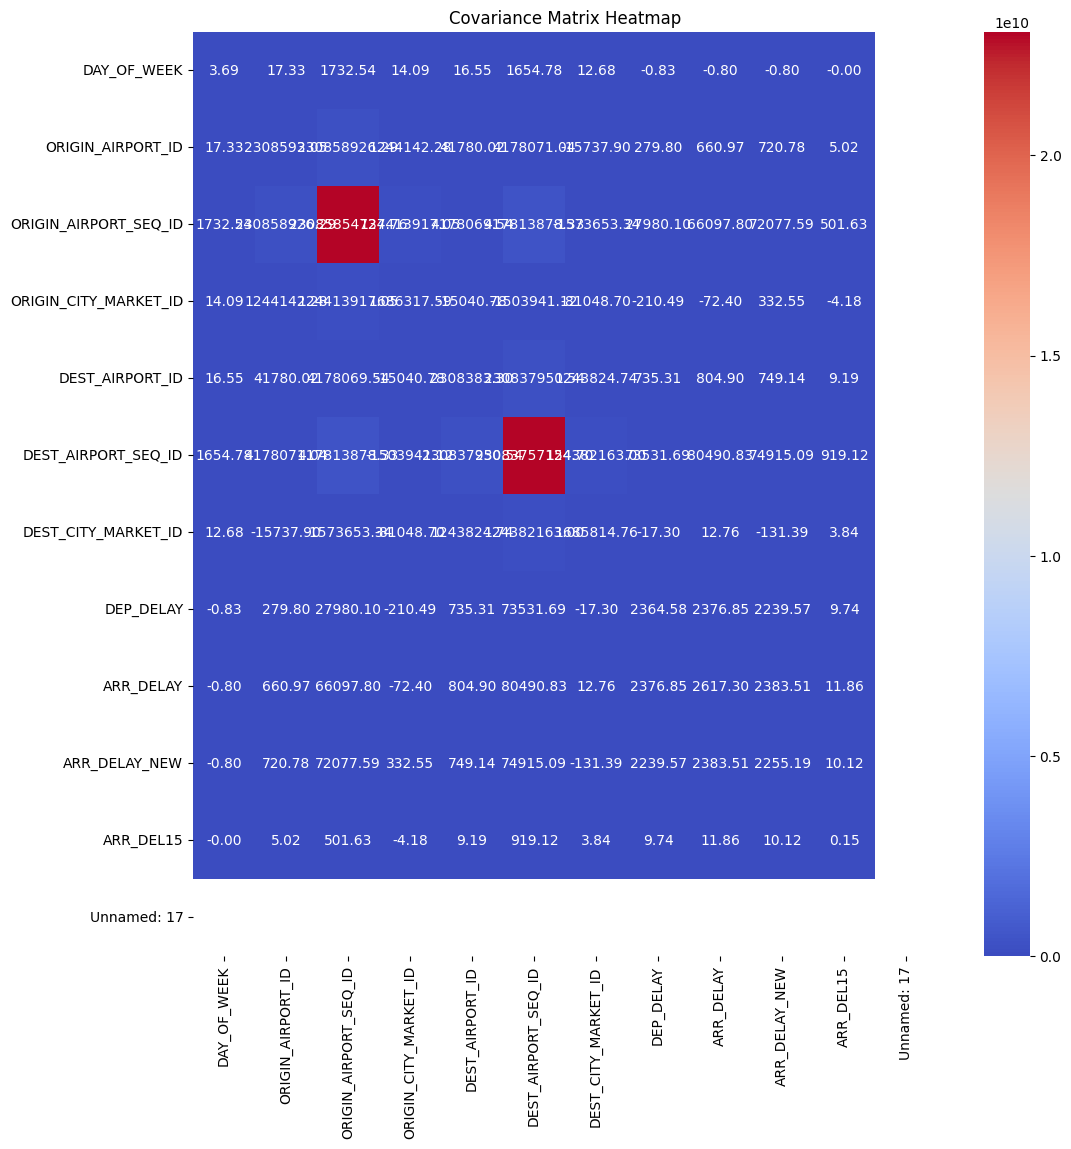

In [ ]:
sns.heatmap(mi_matrix, annot=True, cmap='viridis')
plt.title("Mutual Information Matrix")
plt.show()